In [6]:
# THis python notebook prepare the library for SDR profile 
#due to one load with different Te from 0~20km with 0.1 km increment
import math 
import matplotlib.pyplot as plt
import numpy as np

# #----------------------------------------------------------------
# # Initialization
# #----------------------------------------------------------------
Length = 600000;             #[m] total length 
N = 2001;               # number of node points
dx = Length / (N - 1);       #[m] distance between node points
x = np.linspace(0, Length, N);  #[m] initialize the x array
w = np.zeros((1, N));        #[m] analytic solution to deflection w(x)
#dw = np.zeros((1, N));       #[m] analytic solution to deflection dw(x)
#wn = np.zeros((1, N));       #[m] numerical solution to deflection
dw = np.zeros((N, 1));       #[m] analytic solution to deflection dw(x)
wn = np.zeros((N, 1));       #[m] numerical solution to deflection

Hd = 20000.;              #[m] height of the dike
Te = 20000.;              #[m] effective plate thickness
g = 10.;                 #[m/s**2] gravitational acceleration
rho_d = 3000.;           #[kg/m**3] density of the solidified dike
rho_f = 2800.;           #[kg/m**3] density of the fluid dike
delta_rho_d = rho_d - rho_f;
rho_i_sedi = 2300.;
rho_i = 2800.;           #[kg/m**3] density of the infill
rho_c = 3000.;           #[kg/m**3] density of the underlying lower crust or mantle
sediment = 0;  # whether infill is sedi or lava  (1 means sedi)
if sediment == 1:
    delta_rho_c = rho_c - rho_i_sedi;
else:
    delta_rho_c = rho_c - rho_i;


E = 7.5 * 10.**10.;          #[Pa] Young's modulus; for lame constants of 30GPa
mu = 0.25;              # Poisson's ratio
D = (E * Te**3.) / (12 * (1 - mu**2.)); #[N*m] Flexural rigidity
alpha = (4. * D / (delta_rho_c * g))**0.25;#[m] Flexural wavelength
dV_0 = dx * g * Hd * delta_rho_d; #[N/m] volcanic line load due to denser dike

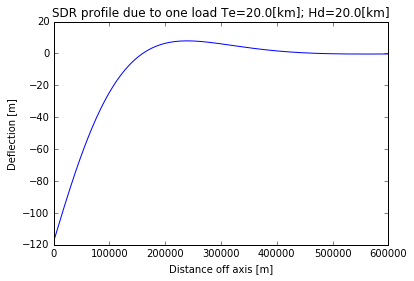

In [3]:
# Analytic plot
dw_0 = 2 * dV_0 / (alpha * g * delta_rho_c)
w_0 = Hd * (delta_rho_d / delta_rho_c);
dw = dw_0 * np.exp(-x/alpha) * np.cos(x/alpha)
w = w_0 * np.exp(- x / alpha) * (np.sin(x/alpha) - np.cos(x/alpha)) + w_0; #(eq.3)
plt.plot(x,-dw)
plt.title("SDR profile due to one load Te={}[km]; Hd={}[km]".format(Te/1000, Hd/1000))
plt.xlabel("Distance off axis [m]")
plt.ylabel("Deflection [m]")
#plt.plot(x,w)
plt.show()

#wn[1:N+1]=0

#wn[2:N-1] = 12

np.shape(np.transpose(wn))

In [4]:
def distributed_q( L,N,wn,g,dx,rho_c,delta_rho_c, D, index_lava):
    # update the L matrix base on new wn
    # distributed_q takes the wn as an argument and calculate the updated 
    # wn 
    # update distributed load q(x) in the coefficients based on calculated wn

    #infill_flag get value of 1 at where wn(x)>=0 and get 0 when wn(x)<0
    infill_flag = (wn >= 0);
    #print(np.shape(infill_flag))
    infill_flag[N-4:N] = 0; # for boundary condition 1~4
    if(index_lava == 1):
        infill_flag[0:N] = 0 #for lava sea condition
    #R = infill_flag * 
    num_i = N;  
    num_j = N - 4;

    coef_i_minus_2 = 1;                         # coefficient for w(i-2) (j == i)
    coef_i_minus_1 = -4;                        # coefficient for w(i-1) (i = j+1)
    coef_i = 6 + delta_rho_c * g / (D / dx**4.);  # coeficient for w(i)   (i = j+2)
    coef_i_wn_positive = 6 + rho_c * g / (D / dx**4.); # coef for wn(x) >= 0
    coef_i_plus_1 = -4.;                         # coefficient for w(i+1) (i = j+3)
    coef_i_plus_2 = 1.;                          # coefficient for w(i+2) (i = j+4)

    #for j = 1:1:num_j
    for j in range(0,num_j):
        #for i = 1:1:num_i
        for i in range(0,num_i):
            if(i == j):
                L[j,i] = coef_i_minus_2;
            elif(i==j+1):
                L[j,i] = coef_i_minus_1;
            elif(i==j+2):
#                print("i={},j={}".format(i,j))
#                print("shape of infill is {}".format(np.shape(infill_flag)))
#                if(infill_flag[i] == False):
                if(infill_flag[i,0] == False):
                    L[j,i] = coef_i;
#                elif(infill_flag[i] == True):
                elif(infill_flag[i,0] == True):
                    L[j,i] = coef_i_wn_positive;  
            elif(i==j+3):
                L[j,i] = coef_i_plus_1;
            elif(i==j+4):
                L[j,i] = coef_i_plus_2;
    return L

L

test = wn>=0

np.shape(test)

test[0,2]

test

np.shape(wn)

0


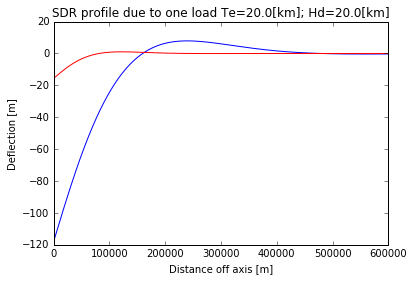

1


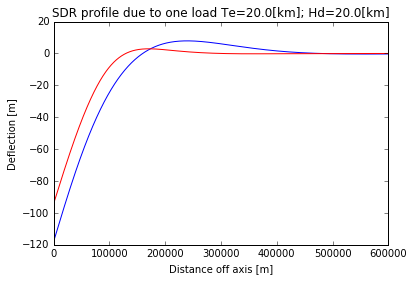

2


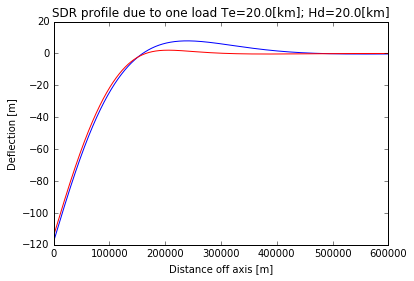

3


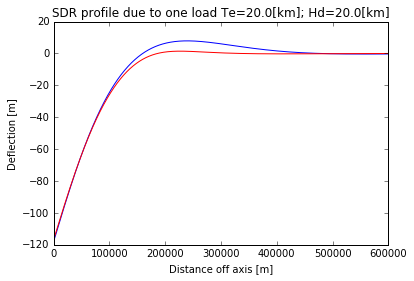

4


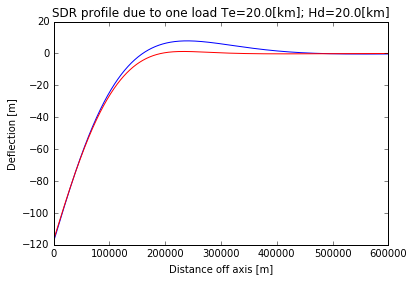

5


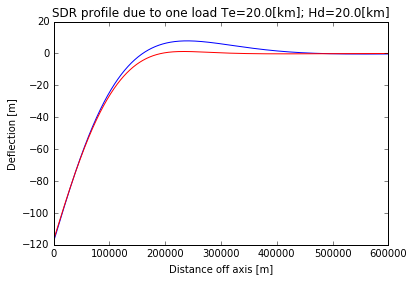

6


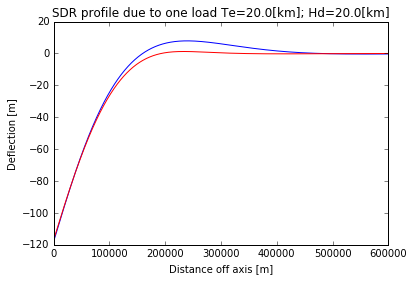

7


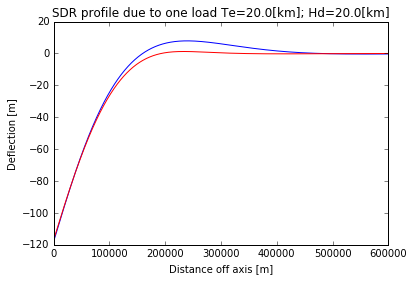

8


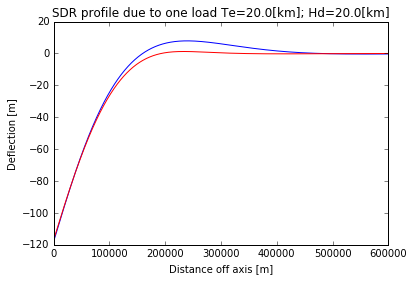

9


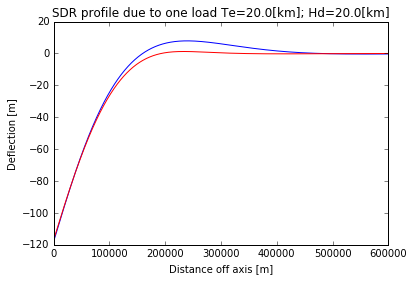

In [5]:
#----------------------------------------------------------------
# Finite difference solution to D * d4w/dx4 + q(x) = 0
# Implicit solution L * W  = R
# L are the corresponding coefficients of w(i-2 ~ i+2)
# W are all the w
# R are the right hand side which are the extra loads
#----------------------------------------------------------------
#----------------------------------------------------------------
# Lava sea or not
#----------------------------------------------------------------
index_lava = 0;
# index_lava = 1 means lava sea where:
                        # q(x) = (rho_i - rho_c) * g * w(x) for any w(x)
# index_lava = 0 means:
                        # q(x) = (rho_i - rho_c) * g at w(x) < 0
                        # q(x) = - rho_c * g at w(x) >= 0
#----------------------------------------------------------------
# Setup the R matrix (N-5+1+4, 1)  # The added 4 is for 4 BCs
#----------------------------------------------------------------
R = np.zeros((N-5+1+4, 1));
#----------------------------------------------------------------
# setup the L matrix (coefficients of w)
# D/dx**4 * (w(i+2) - 4*w(i+1) + 6*w(i) - 4*w(i-1) + w(i-2)) + ...
# delta_rho_c * g * w(i) = 0
#----------------------------------------------------------------
num_i = N-1;  
num_j = N-1 - 4;
L = np.zeros((N, N));
# BC1 approximate line load due to denser dike at the center 
# R(1) = -dV_0 / 2 / (D / dx**4);
# Rather than applying on the RHS of the first equation, we use BCs of 
# V = dV_0 at x = 0

# The remaining four BCs can be added to the L and R matrices
# The row number of the four BCs is random and interchangeable
#---------------------
# BC1: wn(N) = 0;
#---------------------
L[num_j+1,num_i] = 1;
#---------------------
# BC2: w'(inf) = 0;
# wn(N-1) = wn(N);
#---------------------
L[num_j+2,num_i] = 1;
L[num_j+2,num_i-1] = -1;
#---------------------
# BC3: M = 0 at x = 0  --> d2w/dx2|(x=0) = 0
# d2w/dx2 = (wn(i+1) - 2wn(i) + wn(i-1)) / (dx)**2;
# M = -D * d2w/dx2 = -D * (wn(i+1) - 2wn(i) + wn(i-1)) / (dx)**2;
#---------------------
L[num_j+3, 0] = 1;
L[num_j+3, 1] = -2;
L[num_j+3, 2] = 1;
#---------------------
# BC4 V = dM/dx = -D * d3w/dx3 = V_0/2 = dV_0 at x = 0
# d3w/dx3|(i-0.5) = (d2w/dx2|i - d2w/dx2|i-1) / dx
#               = (wn(i+1) -3*wn(i)+3*wn(i-1)-wn(i-2)) / (dx)**3
# -D * (-wn(1) + 3 * wn(2) - 3 * wn(3) + wn(4)) / dx**3;
#---------------------
L[num_j+4, 0] = -1;
L[num_j+4, 1] = 3;
L[num_j+4, 2] = -3;         
L[num_j+4, 3] = 1;
R[num_j+4,0] = dV_0 / (-D/dx**3); # value at the RHS

num_iterate = 6;
#print(num_iterate)
for i in range(0, num_iterate):
# update L base on wn   --> Assigning distributed load q(x)
    print(i)
    L = distributed_q( L,N,wn,g,dx,rho_c,delta_rho_c, D, index_lava); 
    wn = np.linalg.solve(L,R)
    # Analytic plot
    dw_0 = 2 * dV_0 / (alpha * g * delta_rho_c)
    w_0 = Hd * (delta_rho_d / delta_rho_c);
    dw = dw_0 * np.exp(-x/alpha) * np.cos(x/alpha)
    w = w_0 * np.exp(- x / alpha) * (np.sin(x/alpha) - np.cos(x/alpha)) + w_0; #(eq.3)
    plt.plot(x,-dw)
    plt.title("SDR profile due to one load Te={}[km]; Hd={}[km]".format(Te/1000, Hd/1000))
    plt.xlabel("Distance off axis [m]")
    plt.ylabel("Deflection [m]")
    plt.plot(x,wn,'r')
    plt.show()

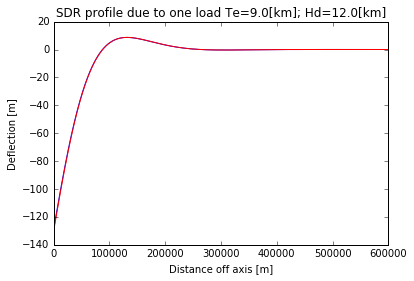

In [19]:
# Analytic plot
dw_0 = 2 * dV_0 / (alpha * g * delta_rho_c)
w_0 = Hd * (delta_rho_d / delta_rho_c);
dw = dw_0 * np.exp(-x/alpha) * np.cos(x/alpha)
w = w_0 * np.exp(- x / alpha) * (np.sin(x/alpha) - np.cos(x/alpha)) + w_0; #(eq.3)
plt.plot(x,-dw)
plt.title("SDR profile due to one load Te={}[km]; Hd={}[km]".format(Te/1000, Hd/1000))
plt.xlabel("Distance off axis [m]")
plt.ylabel("Deflection [m]")
plt.plot(x,wn,'r')
plt.show()

In [6]:
wn

array([[ -1.17027102e+02],
       [ -1.16687691e+02],
       [ -1.16348280e+02],
       ..., 
       [ -2.77394303e-06],
       [ -0.00000000e+00],
       [  0.00000000e+00]])

In [53]:
file_out = open("Te_{}_Hd_{}.txt".format(Te/1000,Hd/1000),"w")

In [54]:
for i in range(N):
    file_out.write("{},".format(wn[i,0]))
file_out.close()

In [2]:
#script for reading the file
file_in = open("Te_{}_Hd_{}.txt".format(20.1,20.0),'r')
for line in file_in:
    kk = line.split(",")
test = np.zeros((N,1))
for i in range(N):
    test[i] = (float(kk[i]))

In [9]:
!pwd

/Users/Tian/Documents/Thesis/Vts_data/TianHe2/20170920/python-scripts


In [12]:
import os
os.mkdir("abc")
os.cd("./abc/")

FileExistsError: [Errno 17] File exists: 'abc'

In [14]:
!pwd

/Users/Tian/Documents/Thesis/Vts_data/TianHe2/20170920/python-scripts
